# **Module**: PLS-based Multivariate Statistical Process Monitoring
## **Lecture**: PLS-based Fault Detection
### *Topic*:  PLS-based fault detection of LDPE reactor

In [4]:
# import required packages
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [5]:
# ==================================================================================
#                        Read and explore dataset
# ==================================================================================

In [6]:
#%% fetch data
data_raw = pd.read_csv('LDPE.csv', usecols = range(1,20))

print("\n First few rows:")
print(data_raw.head())


 First few rows:
      Tin   Tmax1   Tout1   Tmax2   Tout2   Tcin1   Tcin2     z1     z2  \
0  208.17  296.35  233.81  283.41  239.05  117.14  117.20  0.029  0.581   
1  207.26  298.26  230.88  287.55  242.55  116.39  117.23  0.028  0.574   
2  205.30  296.57  235.38  284.35  245.19  117.33  118.42  0.031  0.578   
3  209.29  294.11  225.61  283.31  242.04  116.15  117.94  0.030  0.581   
4  206.76  295.13  230.26  283.74  244.92  116.75  118.49  0.030  0.579   

      Fi1     Fi2     Fs1     Fs2  Press    Conv     Mn      Mw    LCB    SCB  
0  0.4507  0.4518  666.42  248.95   3021  0.1322  27379  160326  0.781  26.11  
1  0.4765  0.5091  658.61  246.36   3033  0.1365  27043  165044  0.819  26.29  
2  0.4744  0.4505  666.51  244.65   3004  0.1335  27344  165621  0.801  26.13  
3  0.4429  0.4516  667.31  242.28   2980  0.1300  27502  160497  0.778  25.92  
4  0.4394  0.4414  670.83  244.31   2997  0.1316  27518  165713  0.786  26.02  


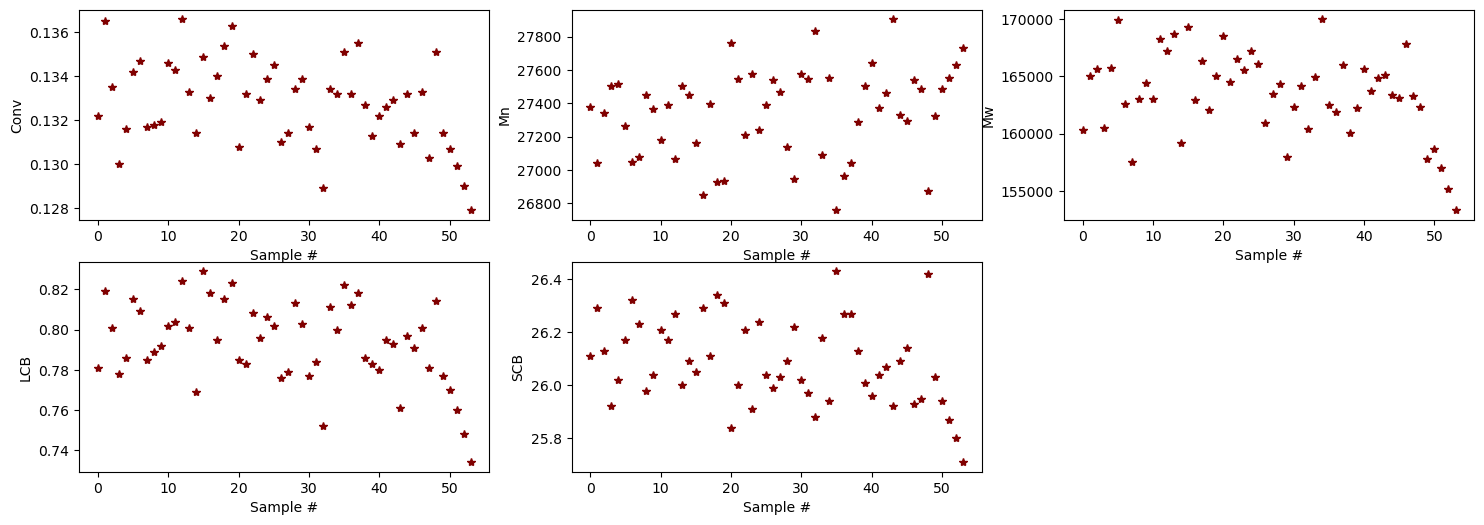

In [7]:
#%% visualize the quality variables
fig, axes = plt.subplots(2, 3, figsize=(18, 6))

# Plot each column directly with matplotlib
axes[0,0].plot(data_raw.iloc[:,-5], '*', color='maroon')
axes[0,0].set_ylabel(data_raw.columns[-5])
axes[0,0].set_xlabel('Sample #')

axes[0,1].plot(data_raw.iloc[:,-4], '*', color='maroon')
axes[0,1].set_ylabel(data_raw.columns[-4])
axes[0,1].set_xlabel('Sample #')

axes[0,2].plot(data_raw.iloc[:,-3], '*', color='maroon')
axes[0,2].set_ylabel(data_raw.columns[-3])
axes[0,2].set_xlabel('Sample #')

axes[1,0].plot(data_raw.iloc[:,-2], '*', color='maroon')
axes[1,0].set_ylabel(data_raw.columns[-2])
axes[1,0].set_xlabel('Sample #')

axes[1,1].plot(data_raw.iloc[:,-1], '*', color='maroon')
axes[1,1].set_ylabel(data_raw.columns[-1])
axes[1,1].set_xlabel('Sample #')

# Remove the last (empty) subplot
fig.delaxes(axes[1,2])

In [8]:
# ==================================================================================
#                              Separate training data 
# ==================================================================================

In [9]:
# separate training data
data = data_raw.values
data_train = data[:-4,:] # exclude last 4 samples
X_train = data_train[:,:-5] # all but last 5 columns
Y_train = data_train[:,-5:] # last 5 columns
           
print('Shape of X_train matrix: ', X_train.shape)
print('Shape of Y_train matrix: ', Y_train.shape)

Shape of X_train matrix:  (50, 14)
Shape of Y_train matrix:  (50, 5)


In [10]:
# ==================================================================================
#                 fit PLS model with the selected number of components
# ==================================================================================

In [11]:
n_comp = 3

In [12]:
# scale data
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
X_train_normal = X_scaler.fit_transform(X_train)
Y_train_normal = Y_scaler.fit_transform(Y_train)
           
# fit PLS (retaining all components by default)
pls = PLSRegression(n_components=n_comp)
pls.fit(X_train_normal, Y_train_normal)

# see the number of components retained
print('Shape of T score matrix: ', pls.x_scores_.shape)
print('Shape of U score matrix: ', pls.y_scores_.shape)

Shape of T score matrix:  (50, 3)
Shape of U score matrix:  (50, 3)


In [13]:
# ==================================================================================
#                Compute fault detection statistics for training samples
# ==================================================================================

In [14]:
# calculate T2 for training samples
Tscores_train = pls.x_scores_

score_variances = np.diag(np.var(Tscores_train, 0, ddof=1)) 
# score_variances = np.cov(Tscores_train.T) # diagonal matrix with diagonal elements as variances of the scores (e.g., T_cov[0,0] is variance of PC1 scores)
score_variances_inv = np.linalg.inv(score_variances)

T2_train = np.zeros((X_train_normal.shape[0],))

for i in range(X_train_normal.shape[0]):
    T2_train[i] = np.dot(np.dot(Tscores_train[i,:], score_variances_inv), Tscores_train[i,:].T)

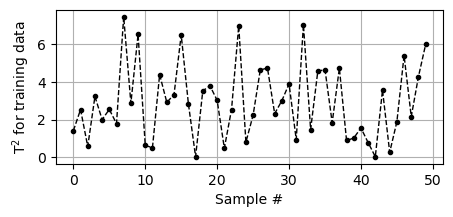

In [15]:
# plot T2_train  
plt.figure(figsize=(5,2))
plt.plot(T2_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.xlabel('Sample #'), plt.ylabel('T$^2$ for training data')
plt.grid()
plt.show()

In [16]:
# calculate SPEx and SPEy for training samples
# SPEx
X_train_normal_reconstruct = np.dot(Tscores_train, pls.x_loadings_.T) # or pls.inverse_transform(Tscores_train)
x_error_train = X_train_normal - X_train_normal_reconstruct
SPEx_train = np.sum(x_error_train*x_error_train, axis = 1)

# SPEy
y_error_train = Y_train_normal - pls.predict(X_train_normal)
SPEy_train = np.sum(y_error_train*y_error_train, axis = 1)

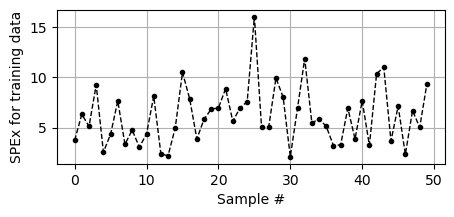

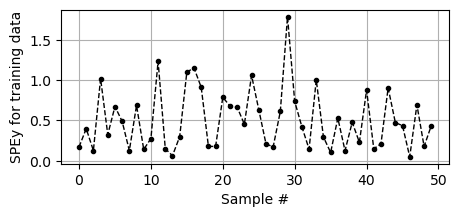

In [17]:
# plot SPEx_train  
plt.figure(figsize=(5,2))
plt.plot(SPEx_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.xlabel('Sample #'), plt.ylabel('SPEx for training data')
plt.grid()
plt.show()

# plot SPEy_train  
plt.figure(figsize=(5,2))
plt.plot(SPEy_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.xlabel('Sample #'), plt.ylabel('SPEy for training data')
plt.grid()
plt.show()

In [18]:
# ==================================================================================
#           Compute control limits for T-squared and Q metrics 
# ==================================================================================

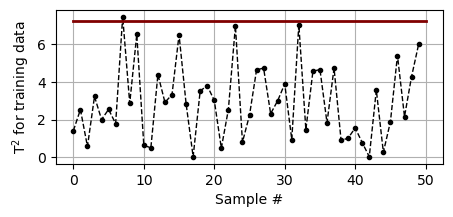

In [19]:
# T2_train control limit
T2_CL = np.percentile(T2_train, 99)

# plot T2_train with control limits
plt.figure(figsize=(5,2))
plt.plot(T2_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(T2_train)],[T2_CL,T2_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('T$^2$ for training data')
plt.grid()
plt.show()

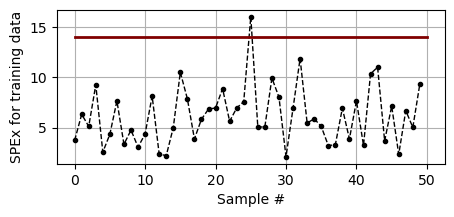

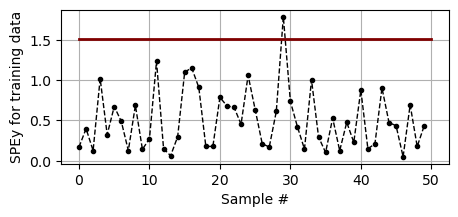

In [20]:
# Q_train control limit
SPEx_CL = np.percentile(SPEx_train, 99)
SPEy_CL = np.percentile(SPEy_train, 99)

# plot Q_train with control limits
plt.figure(figsize=(5,2))
plt.plot(SPEx_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(SPEx_train)],[SPEx_CL,SPEx_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('SPEx for training data')
plt.grid()

plt.figure(figsize=(5,2))
plt.plot(SPEy_train, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(SPEy_train)],[SPEy_CL,SPEy_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('SPEy for training data')
plt.grid()

plt.show()

In [21]:
##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
##              Perform fault detection check for test data
## %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [22]:
# get test data, normalize it
X = data[:,:-5]
Y = data[:,-5:]
X_normal = X_scaler.transform(X)
Y_normal = Y_scaler.transform(Y)

# get scores and model predictions 
Tscores = pls.transform(X_normal)
X_normal_reconstruct = np.dot(Tscores, pls.x_loadings_.T)
Y_normal_pred = pls.predict(X_normal)

In [23]:
# compute monitoring statistics
T2_combined = np.zeros((X_normal.shape[0],))
for i in range(X_normal.shape[0]):
    T2_combined[i] = np.dot(np.dot(Tscores[i,:], score_variances_inv), Tscores[i,:].T)

x_error = X_normal - X_normal_reconstruct
SPEx_combined = np.sum(x_error*x_error, axis = 1)

y_error = Y_normal - Y_normal_pred
SPEy_combined = np.sum(y_error*y_error, axis = 1)

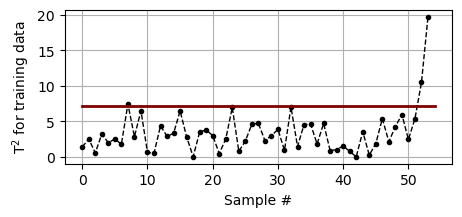

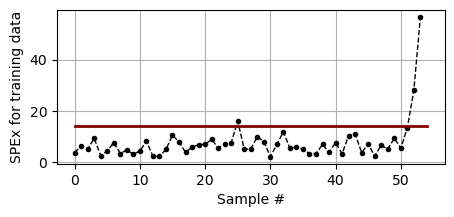

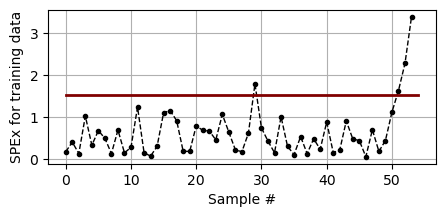

In [24]:
# plot control charts for the complete dataset
plt.figure(figsize=(5,2))
plt.plot(T2_combined, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(T2_combined)],[T2_CL,T2_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('T$^2$ for training data')
plt.grid()

plt.figure(figsize=(5,2))
plt.plot(SPEx_combined, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(SPEx_combined)],[SPEx_CL,SPEx_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('SPEx for training data')
plt.grid()

plt.figure(figsize=(5,2))
plt.plot(SPEy_combined, color='black', linestyle='--', linewidth=1, marker='o', markersize=3)
plt.plot([0,len(SPEy_combined)],[SPEy_CL,SPEy_CL], color='maroon', linewidth=2)
plt.xlabel('Sample #'), plt.ylabel('SPEx for training data')
plt.grid()

plt.show()